#Coding Practice


In [1]:
!nvidia-smi

Tue Jun  7 16:26:06 2022       
+-----------------------------------------------------------------------------+
| NVIDIA-SMI 460.32.03    Driver Version: 460.32.03    CUDA Version: 11.2     |
|-------------------------------+----------------------+----------------------+
| GPU  Name        Persistence-M| Bus-Id        Disp.A | Volatile Uncorr. ECC |
| Fan  Temp  Perf  Pwr:Usage/Cap|         Memory-Usage | GPU-Util  Compute M. |
|                               |                      |               MIG M. |
|===============================+======================+======================|
|   0  Tesla T4            Off  | 00000000:00:04.0 Off |                    0 |
| N/A   52C    P8     9W /  70W |      0MiB / 15109MiB |      0%      Default |
|                               |                      |                  N/A |
+-------------------------------+----------------------+----------------------+
                                                                               
+-------

In [2]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [3]:
!pip install unrar

!unrar x /content/drive/MyDrive/ColabData/COVID-19_Radiography_Dataset.rar

Streaming output truncated to the last 5000 lines.
Extracting  COVID-19_Radiography_Dataset/train/normal/Normal-343.png      63%  OK 
Extracting  COVID-19_Radiography_Dataset/train/normal/Normal-3430.png      63%  OK 
Extracting  COVID-19_Radiography_Dataset/train/normal/Normal-3431.png      63%  OK 
Extracting  COVID-19_Radiography_Dataset/train/normal/Normal-3432.png      63%  OK 
Extracting  COVID-19_Radiography_Dataset/train/normal/Normal-3433.png      63%  OK 
Extracting  COVID-19_Radiography_Dataset/train/normal/Normal-3434.png      63%  OK 
Extracting  COVID-19_Radiography_Dataset/train/normal/Normal-3435.png      63%  OK 
Extracting  COVID-19_Radiography_Dataset/train/normal/Normal-3436.png      63%  OK 
Extracting  COVID-19_Radiography_Dataset/train/normal/Normal-3437.png      63%  OK 
Extracting  COVID-19_Radiography_Dataset/train/normal/Normal-3438.png      63%  OK 
Extracting  COVID-19

#Coding Practice

In [4]:
#How many images in each folder?
import os

#Walk through dataset directory and list number of files
for dirpath, dirnames, filenames in os.walk("COVID-19_Radiography_Dataset"):
  print(f"There are {len(dirnames)} directories and {len(filenames)} images in '{dirpath}'.")

There are 2 directories and 0 images in 'COVID-19_Radiography_Dataset'.
There are 2 directories and 0 images in 'COVID-19_Radiography_Dataset/test'.
There are 0 directories and 2492 images in 'COVID-19_Radiography_Dataset/test/normal'.
There are 0 directories and 846 images in 'COVID-19_Radiography_Dataset/test/covid'.
There are 2 directories and 0 images in 'COVID-19_Radiography_Dataset/train'.
There are 0 directories and 7700 images in 'COVID-19_Radiography_Dataset/train/normal'.
There are 0 directories and 2770 images in 'COVID-19_Radiography_Dataset/train/covid'.


##Creating Data Loaders (preparing the data)

In [5]:
#Setup data inputs
from tensorflow.keras.preprocessing.image import ImageDataGenerator

IMAGE_SHAPE= (224,224)
BATCH_SIZE= 32
EPOCHS = 5

train_dir = "/content/COVID-19_Radiography_Dataset/train"
test_dir = "/content/COVID-19_Radiography_Dataset/test"

train_datagen= ImageDataGenerator(rescale=1/255.)
test_datagen = ImageDataGenerator(rescale=1/255.)

print("Training Images:")
train_data = train_datagen.flow_from_directory(train_dir,
                                                          target_size=IMAGE_SHAPE,
                                                          batch_size=BATCH_SIZE,
                                                          class_mode="binary")

print("Testing Images:")
test_data = test_datagen.flow_from_directory(test_dir,
                                              target_size=IMAGE_SHAPE,
                                              batch_size=BATCH_SIZE,
                                              class_mode="binary")

Training Images:
Found 10470 images belonging to 2 classes.
Testing Images:
Found 3338 images belonging to 2 classes.


In [18]:
class_names = train_data.class_names

plt.figure(figsize=(10, 10))
for images, labels in train_data.take(1):
  for i in range(9):
    ax = plt.subplot(3, 3, i + 1)
    plt.imshow(images[i].numpy().astype("uint8"))
    plt.title(class_names[labels[i]])
    plt.axis("off")

AttributeError: ignored

## Setting up callbacks (things to run whilst or after our model is trains)

Some of the most important callbacks are:
* Tracking experiments with TensorBoard callback
* Model checkpointing with with the ModelCheckpoint callback
* Stopping a model from training (before it trains for too long and overfits with the EarlyStopping callback)

In [6]:
# Create TensorBoard callback (funtionized beacuse we need to create a new one for each model)

import datetime

def create_tensorboard_callback(dir_name, experiment_name):
  log_dir = dir_name + "/" + experiment_name + "/" + datetime.datetime.now().strftime("Y&m&d-&H&M&S")
  tensorboard_callback = tf.keras.callbacks.TensorBoard(log_dir=log_dir)
  print(f"Saving TensorBoard logfiles to {log_dir}")
  return tensorboard_callback

In [7]:
#Let's compare the following two models
resnet_url = "https://tfhub.dev/google/imagenet/resnet_v2_50/feature_vector/5"
efficientnet_url = "https://tfhub.dev/google/efficientnet/b0/feature-vector/1"

In [8]:
# import dependencies
import tensorflow as tf
import tensorflow_hub as hub
from tensorflow.keras import layers

In [9]:
# lets make a create_model() function to create a model from URL
def create_model(model_url, num_classes=2):
  """
  Takes a Tensorflow Hub URL and creates a Keras Sequential Model with it.

  Args:
    model_url (str): A tensorflow hub feature extractor URL.
    num_classes (int): Number of output nequrons in the output layer, should be equal to number of target classes, default 2.

  Returns:
    An uncompiled Keras sequential model with model_url as feature extractor layer and Dense output layer with num_classes output neurons.
  """
  #Download the pre-trained model and save it as Keras layer
  feature_extractor_layer = hub.KerasLayer(model_url,
                                         trainable=False, #Freeze the already learned patterns
                                         name="feature_extractor_layer",
                                         input_shape=IMAGE_SHAPE+(3,)) 

  #Create our own model 
  model = tf.keras.Sequential([feature_extractor_layer,
                             layers.Dense(1, activation="sigmoid", name="output_layer")
                             ])
  return model

###Creating and testing Resnet Tensorflow Hub Feature Extraction Model

In [10]:
#create resnet model
resnet_model = create_model(resnet_url,
                            num_classes=train_data.num_classes)

In [11]:
#Compile our resnet model
resnet_model.compile(loss="binary_crossentropy",
                     optimizer=tf.keras.optimizers.Adam(),
                     metrics=["accuracy"])

In [12]:
resnet_model.summary()

Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 feature_extractor_layer (Ke  (None, 2048)             23564800  
 rasLayer)                                                       
                                                                 
 output_layer (Dense)        (None, 1)                 2049      
                                                                 
Total params: 23,566,849
Trainable params: 2,049
Non-trainable params: 23,564,800
_________________________________________________________________


In [13]:
# Lets fit the resnet model to our data
resnet_history = resnet_model.fit(train_data,
                                  epochs=5,
                                  steps_per_epoch=len(train_data),
                                  validation_data=test_data,
                                  validation_steps=len(test_data),
                                  callbacks=[create_tensorboard_callback(dir_name="tensorflow_hub",
                                                                       experiment_name="ResNet50V2")])

Saving TensorBoard logfiles to tensorflow_hub/ResNet50V2/Y&m&d-&H&M&S
Epoch 1/5
328/328 [==============================] - 76s 176ms/step - loss: 0.2787 - accuracy: 0.8916 - val_loss: 0.3630 - val_accuracy: 0.8526
Epoch 2/5
328/328 [==============================] - 47s 144ms/step - loss: 0.1788 - accuracy: 0.9335 - val_loss: 0.2899 - val_accuracy: 0.8778
Epoch 3/5
328/328 [==============================] - 52s 159ms/step - loss: 0.1549 - accuracy: 0.9440 - val_loss: 0.2609 - val_accuracy: 0.8907
Epoch 4/5
328/328 [==============================] - 47s 143ms/step - loss: 0.1377 - accuracy: 0.9521 - val_loss: 0.2953 - val_accuracy: 0.8814
Epoch 5/5
328/328 [==============================] - 46s 141ms/step - loss: 0.1294 - accuracy: 0.9540 - val_loss: 0.2557 - val_accuracy: 0.8984


#Lets create a function to plot our loss curves
Tidbit: You could a function like this into a script called helper.py and import it when you need it...

In [14]:
import matplotlib.pyplot as plt

#Plot the validation and training curves

def plot_loss_curves(history):
  """
  Returns saperate loss curves for training and validation metrics.

  Args:
    history: Tensorflow history object.

  Returns:
    Plots of training/validation loss and accuracy metrics.
  """
  loss = history.history["loss"]
  val_loss = history.history["val_loss"]

  accuracy = history.history["accuracy"]
  val_accuracy = history.history["val_accuracy"]

  epochs = range (len(history.history["loss"]))

  #Plot loss
  plt.plot(epochs, loss, label="training loss")
  plt.plot(epochs, val_loss, label = "validation loss")
  plt.title("Loss")
  plt.xlabel("epochs")
  plt.legend()

  #Plot Accuracy
  plt.figure()
  plt.plot(epochs, accuracy, label = "Training Accuracy")
  plt.plot (epochs, val_accuracy, label = "Validation Accuracy")
  plt.title("Accuracy")
  plt.xlabel("epochs")
  plt.legend()


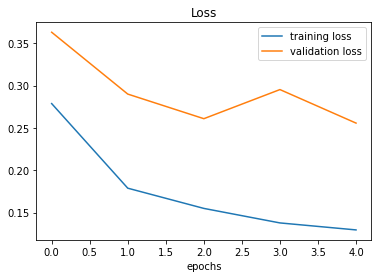

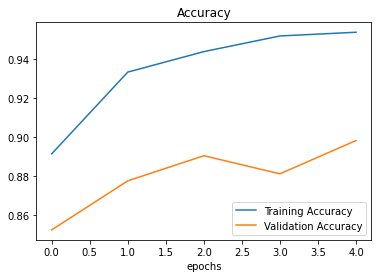

In [15]:
plot_loss_curves(resnet_history)

#Saving the Model

In [16]:
import joblib

joblib.dump(resnet_model, 'resnet_model.pkl')

INFO:tensorflow:Assets written to: ram://4475b11f-60d4-4ff9-9ba9-9fc07111fcc3/assets


INFO:tensorflow:Assets written to: ram://4475b11f-60d4-4ff9-9ba9-9fc07111fcc3/assets


['resnet_model.pkl']

In [17]:
import numpy
from keras.preprocessing.image import load_img
from keras.preprocessing.image import img_to_array
from keras.preprocessing.image import array_to_img

model_from_joblib = joblib.load('resnet_model.pkl')


#Practice of Predict Function

In [28]:
# TensorFlow and tf.keras
import tensorflow as tf

from tensorflow.keras.preprocessing import image

# Helper libraries
import numpy as np
import matplotlib.pyplot as plt

print(tf.__version__)

def classify(img_path):
    img = image.load_img(img_path, target_size=(224, 224))
    img_array = image.img_to_array(img)

    print(img_array)

    img_batch = np.expand_dims(img_array, axis=0)

    img_preprocessed = preprocess_input(img_batch)

    prediction = model_from_joblib.predict(img_preprocessed)

    print(prediction)

classify("/content/Normal-4.png")

2.8.2
[[[ 8.  8.  8.]
  [ 8.  8.  8.]
  [ 8.  8.  8.]
  ...
  [ 8.  8.  8.]
  [ 8.  8.  8.]
  [ 9.  9.  9.]]

 [[ 6.  6.  6.]
  [ 6.  6.  6.]
  [ 6.  6.  6.]
  ...
  [ 0.  0.  0.]
  [ 0.  0.  0.]
  [ 0.  0.  0.]]

 [[ 6.  6.  6.]
  [ 6.  6.  6.]
  [ 6.  6.  6.]
  ...
  [ 0.  0.  0.]
  [ 0.  0.  0.]
  [ 0.  0.  0.]]

 ...

 [[ 0.  0.  0.]
  [ 0.  0.  0.]
  [ 8.  8.  8.]
  ...
  [ 6.  6.  6.]
  [ 6.  6.  6.]
  [ 7.  7.  7.]]

 [[ 0.  0.  0.]
  [ 0.  0.  0.]
  [12. 12. 12.]
  ...
  [ 8.  8.  8.]
  [ 8.  8.  8.]
  [ 9.  9.  9.]]

 [[10. 10. 10.]
  [ 9.  9.  9.]
  [28. 28. 28.]
  ...
  [12. 12. 12.]
  [13. 13. 13.]
  [14. 14. 14.]]]
[[0.]]


#Rough Work

In [ ]:
!pip install flask-ngrok

Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/


In [1]:
import zipfile
from zipfile import ZipFile
file_name='/content/templates.zip'

with ZipFile(file_name, 'r') as zip:
  zip.extractall()
  print('Extracted Successfully')

Extracted Successfully


In [ ]:
!pip install pyngrok==4.1.1

Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/
  Created wheel for pyngrok: filename=pyngrok-4.1.1-py3-none-any.whl size=15983 sha256=be486d4c14cd080006604db232ea1eee6893ee53952bbf17851ba954e8b67ac6
  Stored in directory: /root/.cache/pip/wheels/b1/d9/12/045a042fee3127dc40ba6f5df2798aa2df38c414bf533ca765
Successfully built pyngrok


In [ ]:
!ngrok authtoken 2AD7ECX74LHN5nP90ktXy1mmKbi_26G32nMr6VzFLW6dFrAw8

Authtoken saved to configuration file: /root/.ngrok2/ngrok.yml


In [ ]:
import numpy as np

def load_image(img_path):

    img = image.load_img(img_path, target_size=(224, 224))
    img_tensor = image.img_to_array(img)                    # (height, width, channels)
    img_tensor = np.expand_dims(img_tensor, axis=0)         # (1, height, width, channels), add a dimension because the model expects this shape: (batch_size, height, width, channels)
    img_tensor /= 255.                                      # imshow expects values in the range [0, 1]

    return img_tensor

def prediction(img_path):
    new_image = load_image(img_path)
    
    pred = model.predict(new_image)
    
    return pred
    

In [ ]:
image=load_image('/content/static/COVID-2771.png')

NameError: ignored

In [ ]:
import flask
from flask import Flask, render_template, request
import pickle
import numpy as np
from flask_ngrok import run_with_ngrok
import warnings
warnings.filterwarnings('ignore')

app = Flask(__name__)
run_with_ngrok(app)

model = pickle.load(open('resnet_model.pkl', 'rb'))
@app.route('/', methods=['GET'])
def home():
  return render_template('index.html')

@app.route('/', methods=['POST'])
def predict():
    imagefile = request.files['imagefile']
    image_path = "/content/static/" + imagefile.filename
    imagefile.save(image_path)
    product = prediction(imagefile)
    print(product)

    return render_template('index.html', product)

if __name__ == '__main__':
  app.run()

 * Serving Flask app "__main__" (lazy loading)
 * Environment: production
   Use a production WSGI server instead.
 * Debug mode: off


INFO:werkzeug: * Running on http://127.0.0.1:5000/ (Press CTRL+C to quit)


 * Running on http://2788-34-143-236-87.ngrok.io
 * Traffic stats available on http://127.0.0.1:4040


INFO:werkzeug:127.0.0.1 - - [06/Jun/2022 17:43:13] "GET / HTTP/1.1" 200 -
INFO:werkzeug:127.0.0.1 - - [06/Jun/2022 17:43:14] "GET /favicon.ico HTTP/1.1" 404 -
ERROR:__main__:Exception on / [POST]
Traceback (most recent call last):
  File "/usr/local/lib/python3.7/dist-packages/flask/app.py", line 2447, in wsgi_app
    response = self.full_dispatch_request()
  File "/usr/local/lib/python3.7/dist-packages/flask/app.py", line 1952, in full_dispatch_request
    rv = self.handle_user_exception(e)
  File "/usr/local/lib/python3.7/dist-packages/flask/app.py", line 1821, in handle_user_exception
    reraise(exc_type, exc_value, tb)
  File "/usr/local/lib/python3.7/dist-packages/flask/_compat.py", line 39, in reraise
    raise value
  File "/usr/local/lib/python3.7/dist-packages/flask/app.py", line 1950, in full_dispatch_request
    rv = self.dispatch_request()
  File "/usr/local/lib/python3.7/dist-packages/flask/app.py", line 1936, in dispatch_request
    return self.view_functions[rule.endpoi

###Creating and testing EfficientNetB0 Tensorflow Hub Feature Extraction Model

In [ ]:
#create efficentnetb0 model
efficientnet_model = create_model(efficientnet_url,
                            num_classes=train_data.num_classes)

In [ ]:
#Compile our EfficientB0 model
efficientnet_model.compile(loss="binary_crossentropy",
                     optimizer=tf.keras.optimizers.Adam(),
                     metrics=["accuracy"])

In [ ]:
# Lets fit the resnet model to our data
efficientnet_history = resnet_model.fit(train_data,
                                  epochs=10,
                                  steps_per_epoch=len(train_data),
                                  validation_data=test_data,
                                  validation_steps=len(test_data),
                                  callbacks=[create_tensorboard_callback(dir_name="tensorflow_hub",
                                                                       experiment_name="efficientnetb0")])

Saving TensorBoard logfiles to tensorflow_hub/efficientnetb0/Y&m&d-&H&M&S
Epoch 1/10
328/328 [==============================] - 47s 142ms/step - loss: 0.1187 - accuracy: 0.9590 - val_loss: 0.2351 - val_accuracy: 0.9053
Epoch 2/10
328/328 [==============================] - 45s 136ms/step - loss: 0.1132 - accuracy: 0.9597 - val_loss: 0.2180 - val_accuracy: 0.9125
Epoch 3/10
328/328 [==============================] - 45s 139ms/step - loss: 0.1056 - accuracy: 0.9638 - val_loss: 0.2332 - val_accuracy: 0.9062
Epoch 4/10
328/328 [==============================] - 55s 167ms/step - loss: 0.1008 - accuracy: 0.9663 - val_loss: 0.2790 - val_accuracy: 0.8928
Epoch 5/10
328/328 [==============================] - 44s 135ms/step - loss: 0.0967 - accuracy: 0.9674 - val_loss: 0.2498 - val_accuracy: 0.9032
Epoch 6/10
328/328 [==============================] - 45s 136ms/step - loss: 0.0919 - accuracy: 0.9699 - val_loss: 0.2244 - val_accuracy: 0.9086
Epoch 7/10
328/328 [==============================] - 46

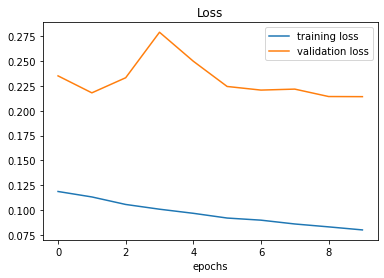

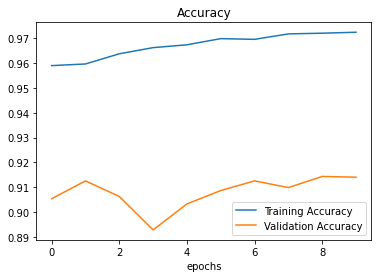

In [ ]:
plot_loss_curves(efficientnet_history)